In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import warnings
warnings.simplefilter("ignore") 
import logging
logging.basicConfig(level=logging.ERROR)

In [4]:
from kinoml.datasets.chembl import ChEMBLDatasetProvider
chembl = ChEMBLDatasetProvider.from_source()

In [5]:
chembl

<ChEMBLDatasetProvider with 203380 pIC50Measurement measurements and 162584 systems>

In [6]:
df = chembl.to_dataframe()
df

,Systems,n_components,Measurement,MeasurementType
0,P00533 & Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F...,2,7.387216,pIC50Measurement
1,P35968 & Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F...,2,4.782516,pIC50Measurement
2,P00533 & Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)...,2,6.769551,pIC50Measurement
3,P06239 & Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C...,2,6.853872,pIC50Measurement
4,P06239 & Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C...,2,5.928118,pIC50Measurement
...,...,...,...,...
203375,P42345 & CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)...,2,8.522879,pKdMeasurement
203376,P42345 & CO[C@H]1CC[C@H](N2C(=O)CNc3ncc(-c4ccc...,2,7.552842,pKdMeasurement
203377,P42345 & CNC(=O)c1cccc(-c2ccc3c(N4CCOC[C@@H]4C...,2,9.853872,pKdMeasurement
203378,P42345 & CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O...,2,9.221849,pKdMeasurement


In [7]:
print("Measurements:", len(chembl.measurements))
print("Systems:", len(chembl.systems))
print("Proteins:", len(set([s.protein for s in chembl.systems])))
print("Ligands:", len(set([s.ligand.name for s in chembl.systems])))
print("Measurement types:", set(df['MeasurementType']))

Measurements: 203380
Systems: 162584
Proteins: 422
Ligands: 103097
Measurement types: {'pIC50Measurement', 'pKiMeasurement', 'pKdMeasurement'}


Having this many ligands (compared to PKIS2) makes this dataset take much more memory and longer (~10 mins) to initialize!

In [8]:
from kinoml.features.ligand import SmilesToLigandFeaturizer, MorganFingerprintFeaturizer
from kinoml.features.protein import AminoAcidCompositionFeaturizer
from kinoml.features.core import ScaleFeaturizer, Concatenated, Pipeline

morgan_featurizer = Pipeline([SmilesToLigandFeaturizer(), MorganFingerprintFeaturizer(nbits=1024, radius=2)])
composition_featurizer = Pipeline([AminoAcidCompositionFeaturizer(), ScaleFeaturizer()])
concat_featurizers = Concatenated([morgan_featurizer, composition_featurizer], axis=0)

You can prefeaturize everything before the loop, or delay the featurization until the systems are needed by passing the featurizer to the `to_pytorch` constructor.

In [9]:
# # prefeaturize everything
# subchembl.featurize(concat_featurizers)
# # pass the featurizer to pytorch to featurize on the fly while optimizing
# datasets = subchembl.to_pytorch(featurizer=concat_featurizers)
# datasets

We are creating a small subset here with just pIC50 measurements:

In [10]:
from kinoml.core.measurements import pIC50Measurement
from kinoml.datasets.chembl import ChEMBLDatasetProvider, _SingleTypeChEMBLDatasetProvider
subset = []
count = 0
for ms in chembl.measurements:
    if isinstance(ms, pIC50Measurement):
        subset.append(ms)
        count += 1
    if count >= 10000:
        break

subchembl = ChEMBLDatasetProvider([_SingleTypeChEMBLDatasetProvider(subset)])
subchembl

<ChEMBLDatasetProvider with 10000 pIC50Measurement measurements and 8514 systems>

In [11]:
subdf = subchembl.to_dataframe()

In [12]:
subdf

,Systems,n_components,Measurement,MeasurementType
0,P00533 & Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F...,2,7.387216,pIC50Measurement
1,P35968 & Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F...,2,4.782516,pIC50Measurement
2,P00533 & Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)...,2,6.769551,pIC50Measurement
3,P06239 & Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C...,2,6.853872,pIC50Measurement
4,P06239 & Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C...,2,5.928118,pIC50Measurement
...,...,...,...,...
9995,Q9Y243 & CC(C)Cc1nc(-c2ccccc2)c(-c2ccc(CN3CCC(...,2,4.660151,pIC50Measurement
9996,P31749 & O=C(O)c1ccc2nc(-c3ccc(CN4CCC(n5c(=O)[...,2,6.619789,pIC50Measurement
9997,P31751 & O=C(O)c1ccc2nc(-c3ccc(CN4CCC(n5c(=O)[...,2,6.551294,pIC50Measurement
9998,P31749 & O=C(O)c1ccc2nc(-c3ccccc3)c(-c3ccc(CN4...,2,6.779892,pIC50Measurement


Min values: 3.00
Max values: 11.52


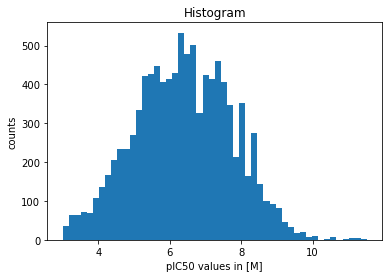

In [13]:
import pandas as pd
from matplotlib import pyplot as plt
def hist_plot(values):
    '''
    Plots the histogram of given values.
    '''
    print(f'Min values: {pd.np.min(values):.2f}')
    print(f'Max values: {pd.np.max(values):.2f}')
    f = plt.figure()
    plt.title("Histogram")
    plt.xlabel("pIC50 values in [M]")
    plt.ylabel("counts")
    plt.hist(values, bins=50)
    plt.show()

hist_plot(subdf.Measurement)

In [14]:
observation_models = subchembl.observation_models(backend="pytorch")
observation_models

[<function kinoml.core.measurements.pIC50Measurement._observation_model_pytorch(dG_over_KT, substrate_conc=1e-06, michaelis_constant=1, inhibitor_conc=1, **kwargs)>]

In [15]:
# prefeaturize everything
subchembl.featurize(concat_featurizers)

Featurizing systems...:  80%|███████▉  | 6789/8514 [01:55<00:32, 53.36it/s]RDKit WARNING: [15:35:15] Conflicting single bond directions around double bond at index 14.
RDKit WARNING: [15:35:15]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [15:35:15] Conflicting single bond directions around double bond at index 14.
RDKit WARNING: [15:35:15]   BondStereo set to STEREONONE and single bond directions set to NONE.
Featurizing systems...: 100%|██████████| 8514/8514 [02:27<00:00, 57.87it/s]


In [16]:
import torch
from kinoml.ml.torch_models import NeuralNetworkRegression
from tqdm.auto import trange, tqdm

# Use DataLoader for minibatches
datasets = subchembl.to_pytorch()
loaders = [dataset.as_dataloader(batch_size=5, shuffle=True) for dataset in datasets]

In [17]:
# precompute input size
input_size = datasets[0].estimate_input_size()
model = NeuralNetworkRegression(input_size=input_size[0])
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_function = torch.nn.MSELoss() # Mean squared error

nb_epoch = 100
loss_timeseries = []
ys = []
range_epochs = trange(nb_epoch, desc="Epochs (+ featurization...)")
for epoch in range_epochs:
    # Single cumulative loss / or loss per loader? look into this!
    cumulative_loss = 0.0
    ys.append([])
    for i, loader in enumerate(loaders):
        for j, (x, y) in enumerate(loader):
            # assert not (torch.isnan(x).any() or torch.isinf(x).any()), f"x has nan and/or infs!"
            # assert not (torch.isnan(y).any() or torch.isinf(y).any()), f"y has nan and/or infs!"

            # Clear gradients
            optimizer.zero_grad()

            # Obtain model prediction given model input
            delta_g = model(x)

            # with observation model
            prediction = loader.dataset.observation_model(delta_g)
            
            # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            # !!! Make sure prediction and y match shapes !!!
            # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            y = y.float()
            y = y.reshape(prediction.shape)

            ys[-1].append((delta_g, prediction, y))

            # prediction = delta_g
            loss = loss_function(prediction, y)

            # Obtain loss for the predicted output
            # if cumulative loss is global, change this i to 0, or viceversa
            cumulative_loss += loss.item()

            # Gradients w.r.t. parameters
            loss.backward()

            # Optimizer
            optimizer.step()
            if j % 2000 == 0:    # print every 2000 mini-batches
                range_epochs.set_description(f"Epochs (loss={cumulative_loss / 2000:.2e})")
                cumulative_loss = 0.0
            
    loss_timeseries.append(cumulative_loss)
    

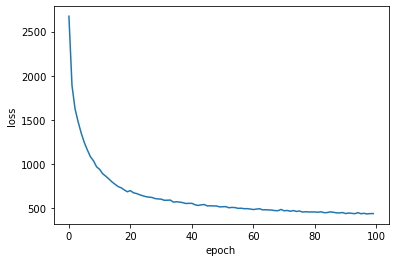

In [18]:
f = plt.figure()
plt.plot(loss_timeseries)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [19]:
import numpy as np
from ipywidgets import interact
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def predicted_vs_true(i=100):
    fig, ax = plt.subplots()
    predicted = np.concatenate([y[1].detach().numpy() for y in ys[i]])
    true = np.concatenate([y[2].detach().numpy() for y in ys[i]]).reshape(-1, 1)
    ax.scatter(predicted, true)
    ax.set(xlim=(0, 15), ylim=(0, 15))
    ax.set_xlabel("Predicted y")
    ax.set_ylabel("True y")
    x = np.linspace(0, 15, 10)
    ax.plot(x, x)
    ax.set_aspect('equal', adjustable='box')
    plt.show()

    r2 = r2_score(true, predicted)
    print(f"R2: Goodness of fit measure: {r2:.2f}")
    if all(elem==predicted[0] for elem in predicted):
        print("All outputs are equal: ")
    mse = mean_squared_error(true, predicted)
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mse)
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")

interact(predicted_vs_true, i=(0, len(ys)-1));

interactive(children=(IntSlider(value=99, description='i', max=99), Output()), _dom_classes=('widget-interact'…

Let's see how the model predicts the whole dataset!

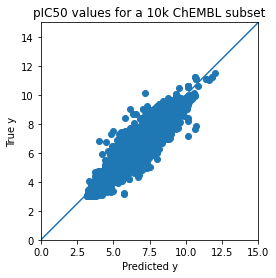

R2: Goodness of fit measure: 0.89
MSE: 0.21
RMSE: 0.46
MAE: 0.33


In [20]:
model_input = torch.tensor(datasets[0].systems).type(torch.FloatTensor)
true = datasets[0].measurements

delta_g = model(model_input)
prediction = datasets[0].observation_model(delta_g).detach().numpy()


fig, ax = plt.subplots()
ax.scatter(prediction, true)
ax.set(xlim=(0, 15), ylim=(0, 15))
ax.set_xlabel("Predicted y")
ax.set_ylabel("True y")
ax.set_title("pIC50 values for a 10k ChEMBL subset")
x = np.linspace(0, 15, 10)
ax.plot(x, x)
ax.set_aspect('equal', adjustable='box')
plt.show()

r2 = r2_score(true, prediction)
print(f"R2: Goodness of fit measure: {r2:.2f}")
if all(elem==prediction[0] for elem in prediction):
    print("All outputs are equal: ")
mse = mean_squared_error(true, prediction)
mae = mean_absolute_error(true, prediction)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# Skorch

Same workflow, but this time using skorch ! 

In [21]:
#!pip install skorch

In [22]:
import skorch
from skorch import NeuralNetRegressor

In [23]:
model_input.shape, type(model_input), true.shape, type(true), true.dtype

(torch.Size([10000, 1044]),
 torch.Tensor,
 (10000,),
 numpy.ndarray,
 dtype('float64'))

In [24]:
y = true.reshape(-1, 1).astype(np.float32)

In [25]:
y.dtype, y.shape

(dtype('float32'), (10000, 1))

In [26]:
net = skorch.regressor.NeuralNetRegressor(module=model,
                           optimizer=torch.optim.Adam, lr=0.005, max_epochs=50, batch_size=64,
                            dataset=datasets[0],
                            # Shuffle training data on each epoch
                            iterator_train__shuffle=True)

In [27]:
y.dtype

dtype('float32')

In [28]:
net.fit(model_input, y)

RuntimeError: Found dtype Double but expected Float
Exception raised from compute_types at /Users/distiller/project/conda/conda-bld/pytorch_1595629430416/work/aten/src/ATen/native/TensorIterator.cpp:183 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >) + 169 (0x12739c199 in libc10.dylib)
frame #1: at::TensorIterator::compute_types(at::TensorIteratorConfig const&) + 3842 (0x11f8e1312 in libtorch_cpu.dylib)
frame #2: at::TensorIterator::build(at::TensorIteratorConfig&) + 618 (0x11f8ea51a in libtorch_cpu.dylib)
frame #3: at::TensorIterator::TensorIterator(at::TensorIteratorConfig&) + 223 (0x11f8ea1ff in libtorch_cpu.dylib)
frame #4: at::native::mse_loss_backward_out(at::Tensor&, at::Tensor const&, at::Tensor const&, at::Tensor const&, long long) + 410 (0x11f735f7a in libtorch_cpu.dylib)
frame #5: at::CPUType::mse_loss_backward_out_grad_input(at::Tensor&, at::Tensor const&, at::Tensor const&, at::Tensor const&, long long) + 9 (0x11fb53fe9 in libtorch_cpu.dylib)
frame #6: at::mse_loss_backward_out(at::Tensor&, at::Tensor const&, at::Tensor const&, at::Tensor const&, long long) + 157 (0x11fc0744d in libtorch_cpu.dylib)
frame #7: at::native::mse_loss_backward(at::Tensor const&, at::Tensor const&, at::Tensor const&, long long) + 118 (0x11f735cf6 in libtorch_cpu.dylib)
frame #8: at::CPUType::mse_loss_backward(at::Tensor const&, at::Tensor const&, at::Tensor const&, long long) + 14 (0x11fb53ffe in libtorch_cpu.dylib)
frame #9: c10::impl::wrap_kernel_functor_unboxed_<c10::impl::detail::WrapFunctionIntoRuntimeFunctor_<at::Tensor (*)(at::Tensor const&, at::Tensor const&, at::Tensor const&, long long), at::Tensor, c10::guts::typelist::typelist<at::Tensor const&, at::Tensor const&, at::Tensor const&, long long> >, at::Tensor (at::Tensor const&, at::Tensor const&, at::Tensor const&, long long)>::call(c10::OperatorKernel*, at::Tensor const&, at::Tensor const&, at::Tensor const&, long long) + 27 (0x11f50587b in libtorch_cpu.dylib)
frame #10: at::Tensor c10::Dispatcher::call<at::Tensor, at::Tensor const&, at::Tensor const&, at::Tensor const&, long long>(c10::TypedOperatorHandle<at::Tensor (at::Tensor const&, at::Tensor const&, at::Tensor const&, long long)> const&, at::Tensor const&, at::Tensor const&, at::Tensor const&, long long) const + 287 (0x11fc3613f in libtorch_cpu.dylib)
frame #11: at::mse_loss_backward(at::Tensor const&, at::Tensor const&, at::Tensor const&, long long) + 157 (0x11fc0751d in libtorch_cpu.dylib)
frame #12: torch::autograd::VariableType::mse_loss_backward(at::Tensor const&, at::Tensor const&, at::Tensor const&, long long) + 900 (0x121bd29f4 in libtorch_cpu.dylib)
frame #13: c10::impl::wrap_kernel_functor_unboxed_<c10::impl::detail::WrapFunctionIntoRuntimeFunctor_<at::Tensor (*)(at::Tensor const&, at::Tensor const&, at::Tensor const&, long long), at::Tensor, c10::guts::typelist::typelist<at::Tensor const&, at::Tensor const&, at::Tensor const&, long long> >, at::Tensor (at::Tensor const&, at::Tensor const&, at::Tensor const&, long long)>::call(c10::OperatorKernel*, at::Tensor const&, at::Tensor const&, at::Tensor const&, long long) + 27 (0x11f50587b in libtorch_cpu.dylib)
frame #14: at::Tensor c10::Dispatcher::call<at::Tensor, at::Tensor const&, at::Tensor const&, at::Tensor const&, long long>(c10::TypedOperatorHandle<at::Tensor (at::Tensor const&, at::Tensor const&, at::Tensor const&, long long)> const&, at::Tensor const&, at::Tensor const&, at::Tensor const&, long long) const + 287 (0x11fc3613f in libtorch_cpu.dylib)
frame #15: at::mse_loss_backward(at::Tensor const&, at::Tensor const&, at::Tensor const&, long long) + 157 (0x11fc0751d in libtorch_cpu.dylib)
frame #16: torch::autograd::generated::MseLossBackward::apply(std::__1::vector<at::Tensor, std::__1::allocator<at::Tensor> >&&) + 298 (0x121a5ddca in libtorch_cpu.dylib)
frame #17: torch::autograd::Node::operator()(std::__1::vector<at::Tensor, std::__1::allocator<at::Tensor> >&&) + 742 (0x1221b7636 in libtorch_cpu.dylib)
frame #18: torch::autograd::Engine::evaluate_function(std::__1::shared_ptr<torch::autograd::GraphTask>&, torch::autograd::Node*, torch::autograd::InputBuffer&, std::__1::shared_ptr<torch::autograd::ReadyQueue> const&) + 1846 (0x1221ac6f6 in libtorch_cpu.dylib)
frame #19: torch::autograd::Engine::thread_main(std::__1::shared_ptr<torch::autograd::GraphTask> const&) + 764 (0x1221ab66c in libtorch_cpu.dylib)
frame #20: torch::autograd::Engine::execute_with_graph_task(std::__1::shared_ptr<torch::autograd::GraphTask> const&, std::__1::shared_ptr<torch::autograd::Node>) + 1023 (0x1221b56cf in libtorch_cpu.dylib)
frame #21: torch::autograd::python::PythonEngine::execute_with_graph_task(std::__1::shared_ptr<torch::autograd::GraphTask> const&, std::__1::shared_ptr<torch::autograd::Node>) + 53 (0x11e601145 in libtorch_python.dylib)
frame #22: torch::autograd::Engine::execute(std::__1::vector<torch::autograd::Edge, std::__1::allocator<torch::autograd::Edge> > const&, std::__1::vector<at::Tensor, std::__1::allocator<at::Tensor> > const&, bool, bool, std::__1::vector<torch::autograd::Edge, std::__1::allocator<torch::autograd::Edge> > const&) + 662 (0x1221b3d36 in libtorch_cpu.dylib)
frame #23: torch::autograd::python::PythonEngine::execute(std::__1::vector<torch::autograd::Edge, std::__1::allocator<torch::autograd::Edge> > const&, std::__1::vector<at::Tensor, std::__1::allocator<at::Tensor> > const&, bool, bool, std::__1::vector<torch::autograd::Edge, std::__1::allocator<torch::autograd::Edge> > const&) + 82 (0x11e600f42 in libtorch_python.dylib)
frame #24: THPEngine_run_backward(THPEngine*, _object*, _object*) + 2174 (0x11e601aee in libtorch_python.dylib)
<omitting python frames>


In [29]:
### There seems to be an issue with the type of y, probably in the Dataset class ?
### Define again a Dataset class in Pytorch. LOOK INTO THIS!

In [30]:
class DNN_input(torch.utils.data.Dataset):
    """DNN input dataset."""

    def __init__(self, array_input, array_output):
        self.array_input = array_input
        self.array_output = array_output

    def __len__(self):
        return len(self.array_input)

    def __getitem__(self, idx):
        return self.array_input[idx], self.array_output[idx]

In [31]:
data = DNN_input(model_input, y)

### Define a custom loss

In [32]:
class CustomLoss(torch.nn.Module):

    def __init__(self):
        super(CustomLoss,self).__init__()

    def forward(self, preds, labels):

        import numpy as np
        
        # This are the paramters of the observation model.
        # TODO: Include them directly! 

        substrate_conc=1e-6
        michaelis_constant=1
        inhibitor_conc=1

        constant = np.log((1 + substrate_conc / michaelis_constant) * inhibitor_conc) / np.log(10)

        return torch.mean((labels+preds/np.log(10) + constant)**2)

In [33]:
criterion = CustomLoss()

Check this notebook for cool functionalities of Skorch
https://nbviewer.jupyter.org/github/skorch-dev/skorch/blob/master/notebooks/Basic_Usage.ipynb

Notice we add early stopping callback.

In [34]:
# Check here https://skorch.readthedocs.io/en/stable/regressor.html
net = skorch.regressor.NeuralNetRegressor(module=model,
                            criterion=CustomLoss,          
                            optimizer=torch.optim.Adam,
                            lr=0.005,
                            max_epochs=50,
                            batch_size=64,
                            #iterator_train= 
                            #iterator_valid=
                            dataset=data,
                            train_split=skorch.dataset.CVSplit(5),
                            callbacks=[skorch.callbacks.EarlyStopping()],
                            verbose=1,
                            device='cpu',
                            # Shuffle training data on each epoch
                            iterator_train__shuffle=True,
                            )

In [35]:
net.fit(datasets[0].systems, y)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1772        0.1581  0.2522
      2        0.1679        0.1530  0.2652
      3        0.1656        0.1645  0.2706
      4        0.1669        0.1540  0.2587
      5        0.1631        0.1579  0.2440
      6        0.1631        0.1629  0.2555
Stopping since valid_loss has not improved in the last 5 epochs.


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=NeuralNetworkRegression(
    (fully_connected_1): Linear(in_features=1044, out_features=100, bias=True)
    (fully_connected_out): Linear(in_features=100, out_features=1, bias=True)
  ),
)

Check how the models performs on the whole data set!

In [36]:
delta_g = net.predict(model_input)
prediction = datasets[0].observation_model(delta_g)

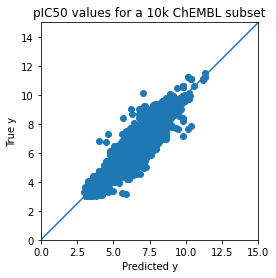

R2: Goodness of fit measure: 0.91
MSE: 0.16
RMSE: 0.40
MAE: 0.27


In [37]:
fig, ax = plt.subplots()
ax.scatter(prediction, true)
ax.set(xlim=(0, 15), ylim=(0, 15))
ax.set_xlabel("Predicted y")
ax.set_ylabel("True y")
ax.set_title("pIC50 values for a 10k ChEMBL subset")
x = np.linspace(0, 15, 10)
ax.plot(x, x)
ax.set_aspect('equal', adjustable='box')
plt.show()

r2 = r2_score(true, prediction)
print(f"R2: Goodness of fit measure: {r2:.2f}")
if all(elem==prediction[0] for elem in prediction):
    print("All outputs are equal: ")
mse = mean_squared_error(true, prediction)
mae = mean_absolute_error(true, prediction)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

In [38]:
from skorch import history
history = net.history
len(history), history[0].keys() 

(7,
 dict_keys(['batches', 'epoch', 'train_batch_count', 'valid_batch_count', 'dur', 'train_loss', 'train_loss_best', 'valid_loss', 'valid_loss_best']))